In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Simulate scaled data

In [2]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import BacSC.util_probe as up
import BacSC.util as ut
import BacSC.NB_est as nb
import BacSC.countsplit as cs
import BacSC.ClusterDE as cd

import importlib

In [3]:
import importlib

## Preprocessing
### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_processed.h5ad")
print(data_gene.obs)

                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACCCAGTGGACCTC-1                395                 5.981414         485.0   
AAACCCATCCTGTAGA-1                558                 6.326149         863.0   
AAACGCTCAGATTTCG-1                398                 5.988961         491.0   
AAACGCTTCTTTGCTA-1                598                 6.395262        1013.0   
AAAGAACCAGTCTGGC-1                897                 6.800170        1190.0   
...                               ...                      ...           ...   
TTTGATCTCCTCGCAT-1                592                 6.385194         924.0   
TTTGGAGCACCGAATT-1               1930                 7.565793        5446.0   
TTTGGAGCAGCAGTTT-1                604                 6.405228         748.0   
TTTGGTTTCGTTGTGA-1                371                 5.918894         470.0   
TTTGTTGAGTAATACG-1               1611                 7.385231        2372.0   

                    log1p_total_counts 

In [5]:
print(type(data_gene.layers["counts"]))
print(type(data_gene.X))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


/tmp/ipykernel_4051923/1438410382.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)


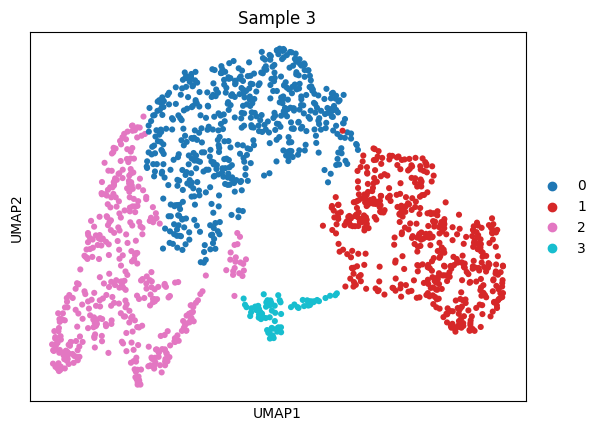

In [6]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Initial DE testing: Wilcoxon rank-sum for every cluster against all others

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


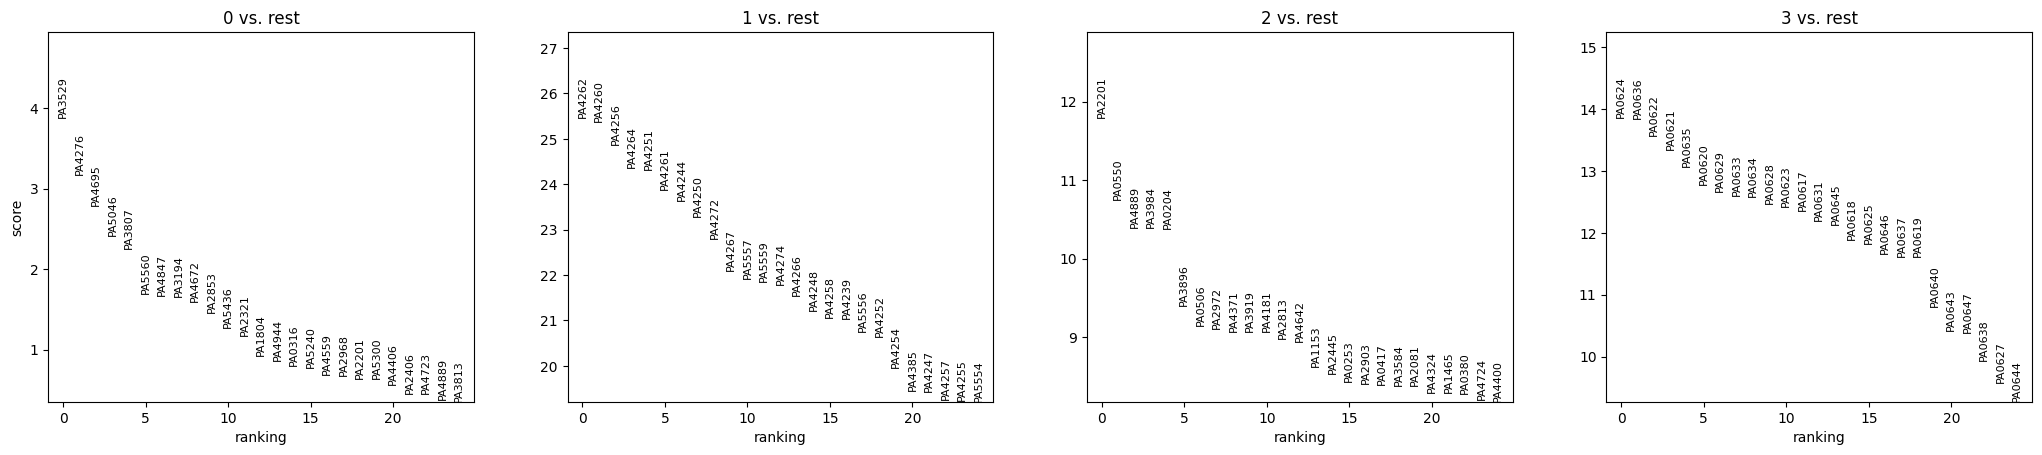

In [7]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [8]:
data_gene_scaled = data_gene.copy()
data_gene_scaled.X = data_gene_scaled.layers["counts"].copy().toarray()
data_gene_scaled.var["var_counts_unscaled"] = np.asarray(np.var(data_gene_scaled.X, axis=0)).squeeze()
data_gene_scaled.var["mean_counts_unscaled"] = np.asarray(np.mean(data_gene_scaled.X, axis=0)).squeeze()
data_gene_scaled.var["total_counts_unscaled"] = np.asarray(np.sum(data_gene_scaled.X, axis=0)).squeeze()

sc.pp.calculate_qc_metrics(data_gene_scaled, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(adata=data_gene_scaled, target_sum=None)
data_gene_scaled.X[data_gene_scaled.X < 1] = np.ceil(data_gene_scaled.X[data_gene_scaled.X < 1])
data_gene_scaled.X = np.round(data_gene_scaled.X, decimals=0)



data_gene_scaled.var["var_counts_scaled"] = np.asarray(np.var(data_gene_scaled.X, axis=0)).squeeze()
data_gene_scaled.var["mean_counts_scaled"] = np.asarray(np.mean(data_gene_scaled.X, axis=0)).squeeze()
data_gene_scaled.var["total_counts_scaled"] = np.asarray(np.sum(data_gene_scaled.X, axis=0)).squeeze()
data_gene_scaled.layers["counts"] = sps.csr_matrix(data_gene_scaled.X.copy())
sc.pp.calculate_qc_metrics(data_gene_scaled, var_type="genes", percent_top=None, log1p=True, inplace=True)

print(data_gene_scaled.obs)


                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACCCAGTGGACCTC-1                395                 5.981414         902.0   
AAACCCATCCTGTAGA-1                558                 6.326149         850.0   
AAACGCTCAGATTTCG-1                398                 5.988961         908.0   
AAACGCTTCTTTGCTA-1                598                 6.395262         921.0   
AAAGAACCAGTCTGGC-1                897                 6.800170         979.0   
...                               ...                      ...           ...   
TTTGATCTCCTCGCAT-1                592                 6.385194         890.0   
TTTGGAGCACCGAATT-1               1930                 7.565793        2157.0   
TTTGGAGCAGCAGTTT-1                604                 6.405228         748.0   
TTTGGTTTCGTTGTGA-1                371                 5.918894         861.0   
TTTGTTGAGTAATACG-1               1611                 7.385231        1677.0   

                    log1p_total_counts 

In [242]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene_scaled, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB n

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 1100
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZIN

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 1800
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZIN

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 2900
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZIN

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not conv

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 4500
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZIN

Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 5300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZIN

In [243]:
print(data_gene_scaled.var)

           feature_types genome  n_cells_by_counts  mean_counts  \
PAO1_ID                                                           
PA0001   Gene Expression   PA01                735     0.572539   
PA0002   Gene Expression   PA01                541     0.408679   
PA0003   Gene Expression   PA01                890     0.724741   
PA0004   Gene Expression   PA01                463     0.334197   
PA0005   Gene Expression   PA01                173     0.122409   
...                  ...    ...                ...          ...   
PA5566   Gene Expression   PA01                 14     0.010363   
PA5567   Gene Expression   PA01                163     0.121114   
PA5568   Gene Expression   PA01                740     0.564767   
PA5569   Gene Expression   PA01               1430     2.330959   
PA5570   Gene Expression   PA01                480     0.386010   

         log1p_mean_counts  pct_dropout_by_counts  total_counts  \
PAO1_ID                                                      


## Find optimal correlation matrix scaling and generate synthetic null data

In [244]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene_scaled, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

Factor: 1 - Error: 46.63176056163104
Factor: 2 - Error: 45.27434943964691
Factor: 3.6180339999999998 - Error: 45.44425936160281
Factor: 2 - Error: 45.27434943964691
Factor: 2.61803399102434 - Error: 44.99002260342424
Factor: 3.000000004452737 - Error: 45.17099682764559
Factor: 2.3819660134283973 - Error: 45.044136940617975
Factor: 2.7639320251291912 - Error: 45.07005653707421
Factor: 2.5278640475332486 - Error: 45.038937061392936
Factor: 2.673762080978214 - Error: 45.030885039082236
Factor: 2.5835921374871225 - Error: 45.068389063901385
Factor: 2.639320227188942 - Error: 45.04014361023946
Factor: 2.604878373651725 - Error: 45.02037753559696
Factor: 2.6261646097200506 - Error: 45.075860481272244
Factor: 2.6130089923474356 - Error: 45.05214311567524
Factor: 2.621139611006372 - Error: 45.009314968953156
Factor: 2.6161146123294676 - Error: 45.059894291234976
Factor: 2.619220232297453 - Error: 45.05872055719851
Factor: 2.617300853602581 - Error: 45.05098724819024
Factor: 2.6184870948703285 

In [245]:
# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)

data_null_gen, R_est = cd.generate_nb_data_copula(data_gene_scaled, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [246]:
print(np.sum(data_null_gen.X, axis=1))

[2000. 2100. 1338. ...  994. 1525. 1165.]


In [247]:
data_null_gen_rescaled = data_null_gen.copy()

data_null_gen_rescaled.X = data_null_gen_rescaled.X / np.sum(data_null_gen_rescaled.X, axis=1, keepdims=True) * data_gene.obs["total_counts"][:, np.newaxis]
print(np.sum(data_null_gen_rescaled.X, axis=1))

[ 485.  863.  491. ...  748.  470. 2372.]


In [248]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()
data_gene_scaled_nonzero = data_gene_scaled[:, data_null_gen.var_names].copy()

In [249]:
sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [250]:
sc.pp.calculate_qc_metrics(data_null_gen_rescaled, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_null_gen_rescaled.var["var_counts"] = np.asarray(np.var(data_null_gen_rescaled.X, axis=0)).squeeze()
data_null_gen_rescaled.var["mean_counts"] = np.asarray(np.mean(data_null_gen_rescaled.X, axis=0)).squeeze()
print(data_null_gen_rescaled.obs)

                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACCCAGTGGACCTC-1               1249                 7.130899         485.0   
AAACCCATCCTGTAGA-1               1344                 7.204149         863.0   
AAACGCTCAGATTTCG-1                785                 6.666957         491.0   
AAACGCTTCTTTGCTA-1                756                 6.629363        1013.0   
AAAGAACCAGTCTGGC-1                968                 6.876265        1190.0   
...                               ...                      ...           ...   
TTTGATCTCCTCGCAT-1               1079                 6.984716         924.0   
TTTGGAGCACCGAATT-1                817                 6.706862        5446.0   
TTTGGAGCAGCAGTTT-1                669                 6.507278         748.0   
TTTGGTTTCGTTGTGA-1               1012                 6.920672         470.0   
TTTGTTGAGTAATACG-1                856                 6.753438        2372.0   

                    log1p_total_counts 

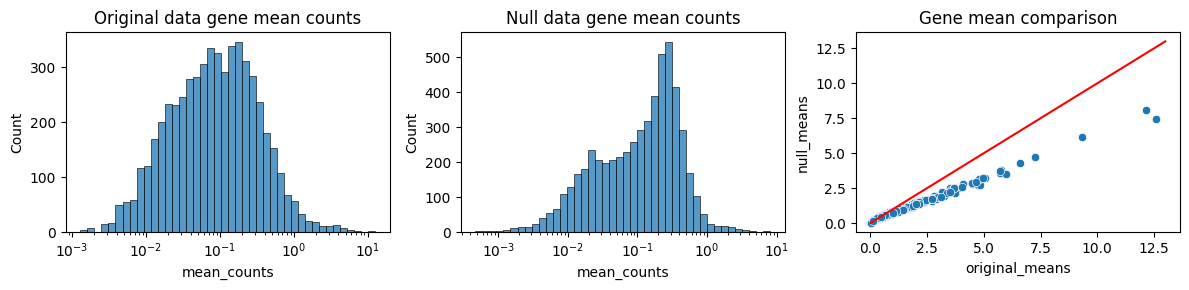

SignificanceResult(statistic=0.9923789100729431, pvalue=0.0)


In [255]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen_rescaled.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen_rescaled.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

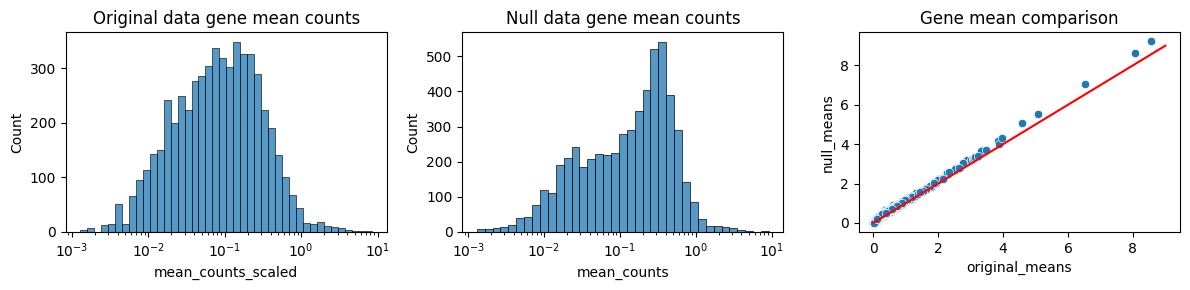

SignificanceResult(statistic=0.9934445893913585, pvalue=0.0)


In [256]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_scaled_nonzero.var, x="mean_counts_scaled", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_scaled_nonzero.var["mean_counts_scaled"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_scaled_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_scaled_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

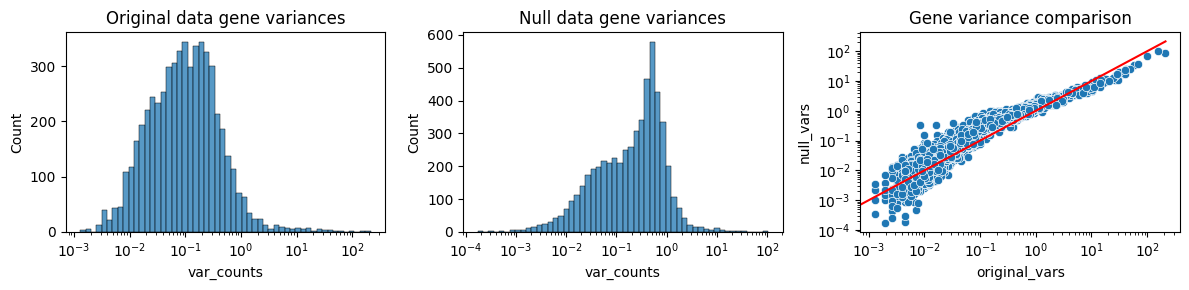

SignificanceResult(statistic=0.9715677508708529, pvalue=0.0)
[[1.         0.97207071]
 [0.97207071 1.        ]]


In [257]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen_rescaled.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen_rescaled.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

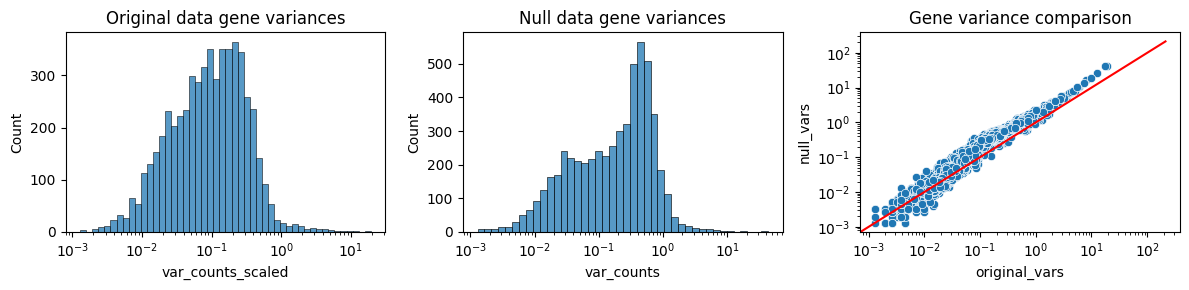

SignificanceResult(statistic=0.9874582439037464, pvalue=0.0)
[[1.         0.98826635]
 [0.98826635 1.        ]]


In [258]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_scaled_nonzero.var, x="var_counts_scaled", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_scaled_nonzero.var["var_counts_scaled"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_scaled_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_scaled_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

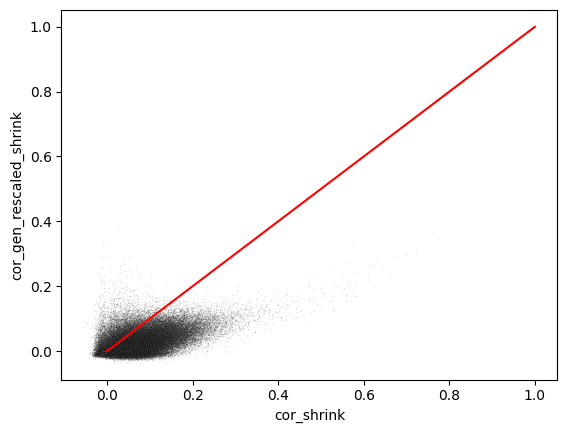

In [259]:
cor_orig = spearmanr(data_gene_nonzero.layers["counts"].toarray()).statistic
cor_orig = pd.DataFrame(cor_orig, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_orig_scaled = spearmanr(data_gene_scaled_nonzero.layers["counts"].toarray()).statistic
cor_orig_scaled = pd.DataFrame(cor_orig_scaled, index=data_gene_scaled_nonzero.var_names, columns=data_gene_scaled_nonzero.var_names)

cor_gen = spearmanr(data_null_gen.X).statistic
cor_gen = pd.DataFrame(cor_gen, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_rescaled = spearmanr(data_null_gen_rescaled.X).statistic
cor_gen_rescaled = pd.DataFrame(cor_gen_rescaled, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_scaled_shrink = cd.schaefer_strimmer(data_gene_scaled_nonzero.layers["counts"].toarray(), use_corr=True)
cor_scaled_shrink = pd.DataFrame(cor_scaled_shrink, index=data_gene_scaled_nonzero.var_names, columns=data_gene_scaled_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_rescaled_shrink = cd.schaefer_strimmer(data_null_gen_rescaled.X, use_corr=True)
cor_gen_rescaled_shrink = pd.DataFrame(cor_gen_rescaled_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({
    "cor_orig": cor_orig.values.flatten(), 
    "cor_orig_scaled": cor_orig_scaled.values.flatten(), 
    "cor_gen": cor_gen.values.flatten(), 
    "cor_gen_rescaled": cor_gen_rescaled.values.flatten(),
    "cor_shrink": cor_shrink.values.flatten(), 
    "cor_scaled_shrink": cor_scaled_shrink.values.flatten(), 
    "cor_gen_shrink": cor_gen_shrink.values.flatten(),
    "cor_gen_rescaled_shrink": cor_gen_rescaled_shrink.values.flatten()

})
all_cors["ratio"] = all_cors["cor_orig"]/all_cors["cor_gen_rescaled"]

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_shrink", y="cor_gen_rescaled_shrink", s=1, color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

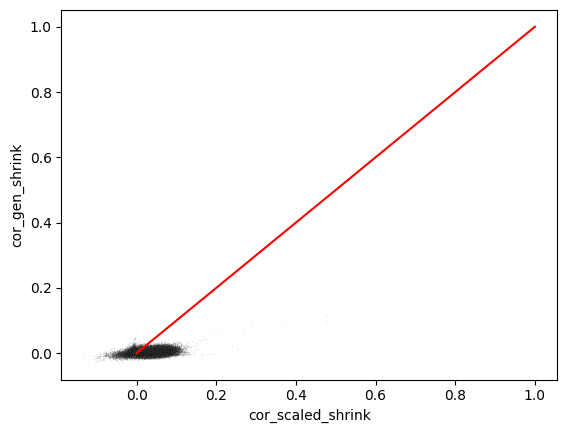

In [260]:
sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_scaled_shrink", y="cor_gen_shrink", s=1, color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

In [185]:
data_null_gen.layers["counts"] = data_null_gen.X.copy()
data_null_gen_rescaled.layers["counts"] = data_null_gen_rescaled.X.copy()

### Process null data

In [186]:
sc.pp.calculate_qc_metrics(data_null_gen_rescaled)
data_null_gen_rescaled.var["var_counts_scaled"] = np.asarray(np.var(data_null_gen_rescaled.X, axis=0)).squeeze()
data_null_gen_rescaled.var["mean_counts_scaled"] = np.asarray(np.mean(data_null_gen_rescaled.X, axis=0)).squeeze()

In [187]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen_rescaled, flavor="sctransform")

k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_null_gen_rescaled, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen_rescaled, target_sum=None, layer=None)
data_null_gen_rescaled.X = sps.csr_matrix(np.log(data_null_gen_rescaled.X + np.array(data_null_gen_rescaled.var["nb_overdisp"] / 4)))
data_null_gen_rescaled.layers["vst_counts"] = data_null_gen_rescaled.X.copy()
sc.pp.scale(data_null_gen_rescaled, max_value=10, zero_center=True)
data_null_gen_rescaled.X[np.isnan(data_null_gen_rescaled.X)] = 0
sc.tl.pca(data_null_gen_rescaled, svd_solver='arpack')
sc.pp.neighbors(data_null_gen_rescaled, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen_rescaled, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


In [188]:
data_null_gen_rescaled.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,var_counts,var_counts_scaled,mean_counts_scaled,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,,,
PA0001,643,0.647686,0.499372,58.354922,1000.027261,6.908782,1.563652,1.563652,0.647686,False,1.513429,1.513429,-7.482005,2.295231,-7.202837,2.209558,0.117134,-0.431772,0.668780
PA0002,483,0.441061,0.365380,68.717617,680.998051,6.525027,0.991570,0.991570,0.441061,False,1.060472,1.060472,-7.886562,2.303667,-7.710640,2.248629,0.104660,-0.859682,0.711373
PA0003,792,0.848015,0.614112,48.704663,1309.335280,7.178038,2.041480,2.041480,0.848015,False,1.955117,1.955117,-7.190130,2.290795,NaN,NaN,NaN,-0.129037,0.610019
PA0004,430,0.370585,0.315237,72.150259,572.182611,6.351204,0.662124,0.662124,0.370585,False,0.914168,0.914168,-8.035528,2.304318,-7.488750,2.123270,0.091011,-1.037415,0.718326
PA0005,165,0.129179,0.121491,89.313472,199.452283,5.300576,0.288926,0.288926,0.129179,False,0.286809,0.286809,-9.100354,2.302536,NaN,NaN,NaN,-2.364843,0.786021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,11,0.008888,0.008849,99.287565,13.723646,2.689455,0.015577,0.015577,0.008888,False,0.024651,0.024651,-10.243037,1.788380,NaN,NaN,NaN,-5.053199,0.427297
PA5567,145,0.114664,0.108553,90.608808,177.041122,5.182015,0.220877,0.220877,0.114664,False,0.255862,0.255862,-9.201024,2.300393,-8.660098,2.122722,0.090353,-2.500512,0.777309
PA5568,680,0.664440,0.509489,55.958549,1025.895625,6.934296,1.726137,1.726137,0.664440,False,1.558978,1.558978,-7.447258,2.294503,NaN,NaN,NaN,-0.391827,0.647098


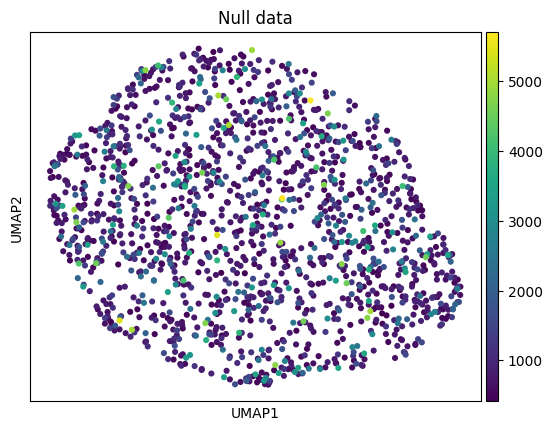

In [ ]:
sc.pl.umap(data_null_gen_rescaled, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [190]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen_rescaled, resolution=res2, key_added="leiden", random_state=None)
    nclust = len(data_null_gen_rescaled.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

0.05
Resolution for two clusters: 0.09


In [ ]:
sc.pl.umap(data_null_gen_rescaled, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [ ]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [192]:
X_null_gen_0 = data_null_gen_rescaled.X[data_null_gen_rescaled.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen_rescaled.X[data_null_gen_rescaled.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [193]:
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 0.10499490316004077
Cluster 1 - DE genes: 147; Minimum q value: 0.009900990099009901
Cluster 2 - DE genes: 5315; Minimum q value: 0.004759071980963712
Cluster 3 - DE genes: 0; Minimum q value: 1.0


In [194]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 1988; Minimum q value: 0.039619651347068144
Cluster 1 - DE genes: 0; Minimum q value: 0.5
Cluster 2 - DE genes: 5315; Minimum q value: 0.008849557522123894
Cluster 3 - DE genes: 0; Minimum q value: 1.0


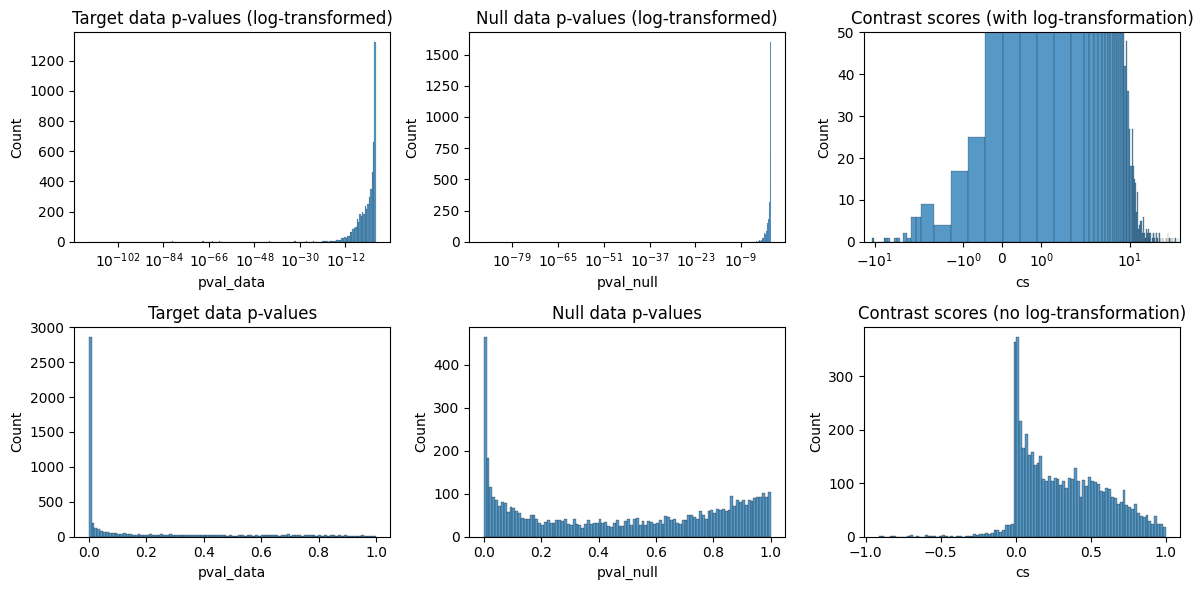

In [195]:
c = "2"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog", ylim=(0, 50))

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [196]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
0.104995    2943
0.105299       1
0.105548      12
0.105779       3
0.105938       5
            ... 
0.193138       1
0.193187       4
0.193243       9
0.193763       3
1.000000     900
Name: q, Length: 332, dtype: int64

cluster 1
0.009901     101
0.026087      14
0.032000      10
0.037879       7
0.042254      10
            ... 
0.669379       1
0.669476       4
0.669576       1
0.669976       1
1.000000    2226
Name: q, Length: 219, dtype: int64

cluster 2
0.004759    1681
0.005248      34
0.005650     232
0.006042      39
0.006410      42
            ... 
0.043699       4
0.043855       4
0.044035       1
0.044403       1
1.000000     235
Name: q, Length: 178, dtype: int64

cluster 3
1.0    5550
Name: q, dtype: int64



In [225]:
pvals_log_gen["2"].sort_values("pval_data")

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA4264,3.063816e-114,2.219662e-88,113.513737,87.653713,25.860024,0.004759
PA4256,1.839384e-109,9.530314e-69,108.735328,68.020893,40.714435,0.004759
PA4262,7.009442e-106,4.712496e-73,105.154317,72.326749,32.827568,0.004759
PA4260,5.837065e-105,4.733768e-67,104.233805,66.324793,37.909012,0.004759
PA4267,8.369181e-88,7.658551e-59,87.077317,58.115853,28.961464,0.004759
...,...,...,...,...,...,...
PA3586,9.978972e-01,9.836553e-01,0.000914,0.007157,-0.006243,1.000000
PA4570,9.979998e-01,9.598631e-01,0.000870,0.017791,-0.016921,1.000000
PA4981,9.983075e-01,8.838103e-01,0.000736,0.053641,-0.052905,1.000000


In [198]:
pvals_log_gen["0"]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
PAO1_ID,,,,,,
PA5315,1.530448e-13,1.556110e-01,12.815181,0.807960,12.007221,0.104995
PA3010,3.553747e-11,2.772104e-01,10.449313,0.557190,9.892123,0.104995
PA0649,1.425764e-10,9.112969e-01,9.845952,0.040340,9.805612,0.104995
PA3161,2.110355e-10,7.375982e-01,9.675644,0.132180,9.543464,0.104995
PA1271,1.972031e-12,5.115949e-03,11.705086,2.291074,9.414012,0.104995
...,...,...,...,...,...,...
PA5557,1.314743e-04,7.049327e-61,3.881159,60.151852,-56.270693,1.000000
PA4260,2.674890e-05,4.733768e-67,4.572694,66.324793,-61.752099,1.000000
PA4256,2.996901e-04,9.530314e-69,3.523328,68.020893,-64.497565,1.000000


In [ ]:
# goi = pvals_log_gen["3"].sort_values("pval_null", ascending=True).index[:10]
goi = ['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252',
       'PA4274', 'PA4250', 'PA5556']
print(goi)

sc.pl.umap(data_null_gen_rescaled, color=goi, cmap="viridis")

['PA4264', 'PA4260', 'PA4262', 'PA4256', 'PA4251', 'PA4267', 'PA4252', 'PA4274', 'PA4250', 'PA5556']


## Testing...

In [200]:
nb.estimate_overdisp_nb(data_gene, flavor="sctransform", layer="counts")
nb.estimate_overdisp_nb(data_gene_scaled, flavor="sctransform", layer="counts")


Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')
Index(['Intercept_sct', 'log_umi_sct', 'theta_sct', 'is_scd_outlier_sct',
       'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct',
       'genes_step1_sct', 'log10_gmean_sct', 'is_scd_outlier'],
      dtype='object')


In [201]:
nb_est_df_null = data_null_gen_rescaled.var.reset_index()[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_null["type"] = "null"

nb_est_df_gene = data_gene.var[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_gene["type"] = "real"

nb_est_df_gene_scaled = data_gene_scaled.var[["nb_mean", "nb_overdisp", "nb_overdisp_cutoff", "mean_counts", "var_counts", "n_cells_by_counts", "PAO1_ID", "nb_umi", "Intercept_step1_sct", "log_umi_step1_sct", "dispersion_step1_sct", "total_counts"]]
nb_est_df_gene_scaled["type"] = "real_scaled"

nb_est_df = pd.concat([nb_est_df_null, nb_est_df_gene, nb_est_df_gene_scaled]).reset_index()
nb_est_df

,index,nb_mean,nb_overdisp,nb_overdisp_cutoff,mean_counts,var_counts,n_cells_by_counts,PAO1_ID,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct,total_counts,type
0,0,-7.482005,1.513429,1.513429,0.647686,1.563652,643,PA0001,2.295231,-7.202837,2.209558,0.117134,1000.027261,null
1,1,-7.886562,1.060472,1.060472,0.441061,0.991570,483,PA0002,2.303667,-7.710640,2.248629,0.104660,680.998051,null
2,2,-7.190130,1.955117,1.955117,0.848015,2.041480,792,PA0003,2.290795,NaN,NaN,NaN,1309.335280,null
3,3,-8.035528,0.914168,0.914168,0.370585,0.662124,430,PA0004,2.304318,-7.488750,2.123270,0.091011,572.182611,null
4,4,-9.100354,0.286809,0.286809,0.129179,0.288926,165,PA0005,2.302536,NaN,NaN,NaN,199.452283,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16651,PA5566,-16.707652,0.068089,0.068089,0.010363,0.010916,14,PA5566,3.994519,-10.484405,1.975077,0.067454,16.000000,real_scaled
16652,PA5567,-13.584191,2.122179,2.122179,0.121114,0.161347,163,PA5567,3.793931,NaN,NaN,NaN,187.000000,real_scaled
16653,PA5568,-5.520266,20.398145,20.398145,0.564767,0.750315,740,PA5568,1.657166,-5.842968,1.761787,0.007894,872.000000,real_scaled
16654,PA5569,1.550583,14.664585,14.664585,2.330959,14.170981,1430,PA5569,-0.229794,0.555871,0.097645,0.013771,3599.000000,real_scaled


In [202]:
nb_est_df["nb_est"] = np.exp(nb_est_df["Intercept_step1_sct"] + nb_est_df["log_umi_step1_sct"] * np.log10(nb_est_df["total_counts"]))
nb_est_df["nb_est_smoothed"] = np.exp(nb_est_df["nb_mean"] + nb_est_df["nb_umi"] * np.log10(nb_est_df["total_counts"]))


[None, None]

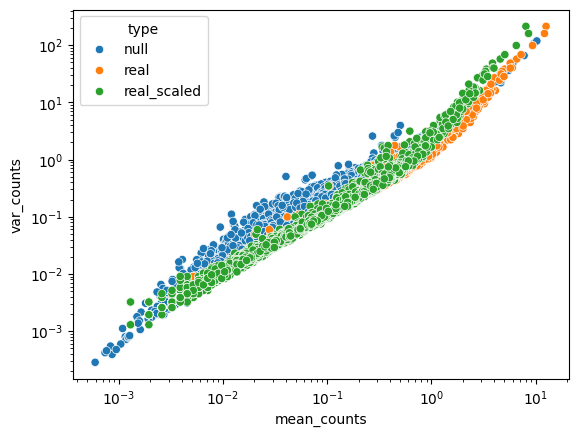

In [203]:
g = sns.scatterplot(nb_est_df, x="mean_counts", y="var_counts", hue="type")
g.set(xscale="log", yscale="log")

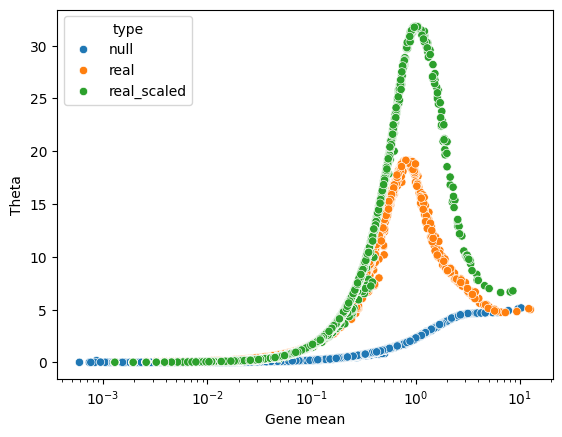

In [205]:
g = sns.scatterplot(data=nb_est_df, y="nb_overdisp_cutoff", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

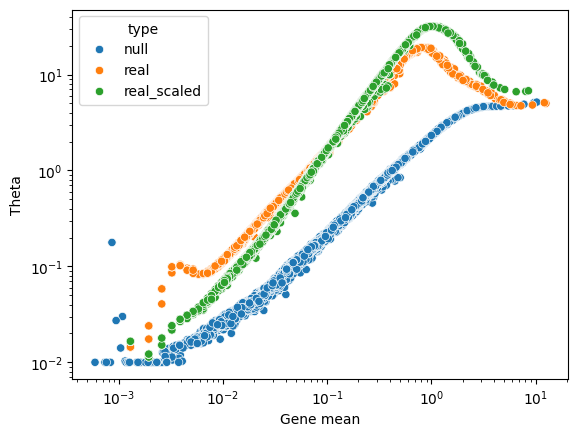

In [206]:
g = sns.scatterplot(data=nb_est_df, y="nb_overdisp_cutoff", x="mean_counts", hue="type")
g.set(xscale="log", yscale="log")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

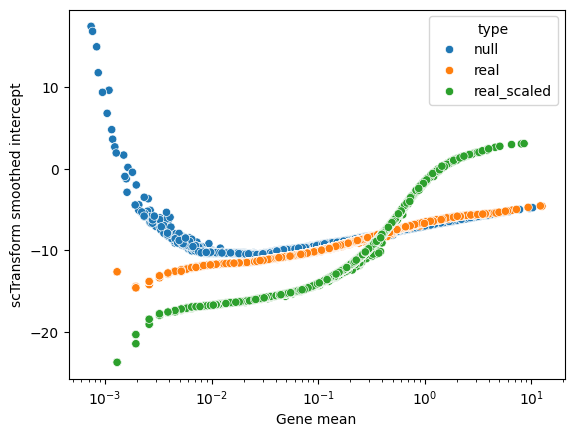

In [207]:
g = sns.scatterplot(data=nb_est_df, y="nb_mean", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform smoothed intercept")
plt.show()

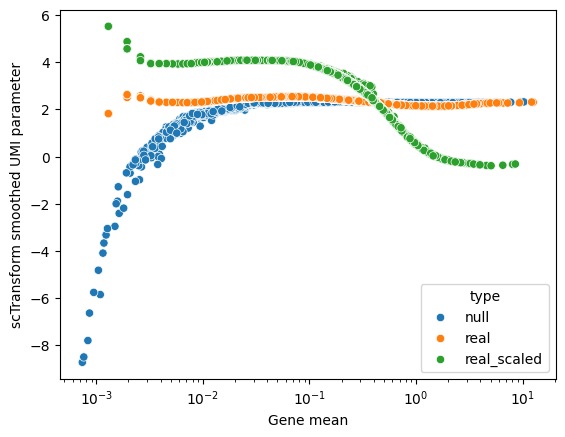

In [208]:
g = sns.scatterplot(data=nb_est_df, y="nb_umi", x="mean_counts", hue="type")
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform smoothed UMI parameter")
plt.show()

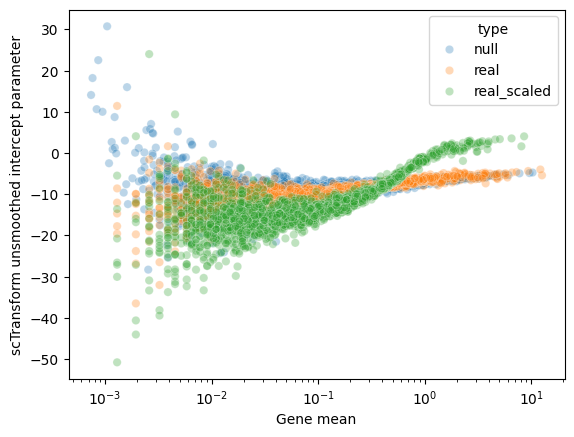

In [209]:
g = sns.scatterplot(data=nb_est_df, y="Intercept_step1_sct", x="mean_counts", hue="type", alpha=0.3)
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed intercept parameter")
plt.show()

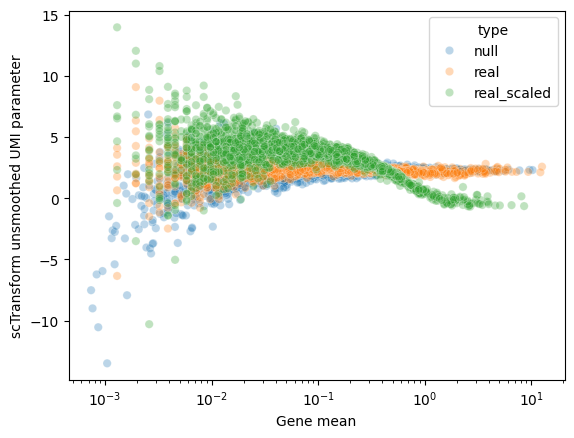

In [ ]:
g = sns.scatterplot(data=nb_est_df, y="log_umi_step1_sct", x="mean_counts", hue="type", alpha=0.3)
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed UMI parameter")
plt.show()

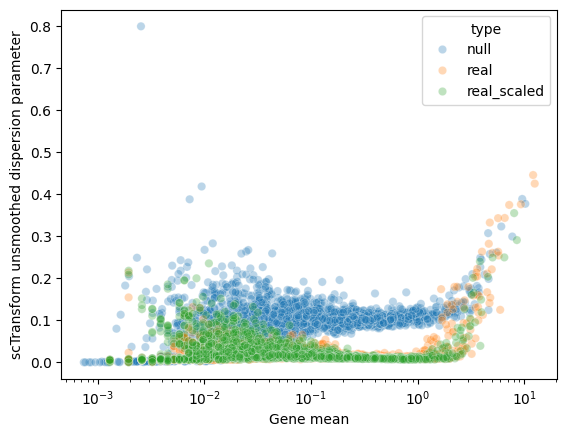

In [217]:
g = sns.scatterplot(data=nb_est_df, y="dispersion_step1_sct", x="mean_counts", hue="type", alpha=0.3)
g.set(xscale="log")
plt.xlabel("Gene mean")
plt.ylabel("scTransform unsmoothed dispersion parameter")
plt.show()

In [218]:
nb_est_df_paired = nb_est_df.pivot(index="PAO1_ID", columns="type")
nb_est_df_paired.columns = ['_'.join(col).strip() for col in nb_est_df_paired.columns.values]
nb_est_df_paired

,index_null,index_real,index_real_scaled,nb_mean_null,nb_mean_real,nb_mean_real_scaled,nb_overdisp_null,nb_overdisp_real,nb_overdisp_real_scaled,nb_overdisp_cutoff_null,...,dispersion_step1_sct_real_scaled,total_counts_null,total_counts_real,total_counts_real_scaled,nb_est_null,nb_est_real,nb_est_real_scaled,nb_est_smoothed_null,nb_est_smoothed_real,nb_est_smoothed_real_scaled
PAO1_ID,,,,,,,,,,,,,,,,,,,,,
PA0001,0,PA0001,PA0001,-7.482005,-7.099235,-5.478218,1.513429,17.800106,20.543288,1.513429,...,0.008416,1000.027261,1029.0,884.0,0.563191,0.602006,0.525465,0.550854,0.605596,0.532024
PA0002,1,PA0002,PA0002,-7.886562,-7.703342,-7.916774,1.060472,12.332841,12.938235,1.060472,...,0.010598,680.998051,724.0,631.0,0.261860,NaN,0.250522,0.256677,0.290053,0.254152
PA0003,2,PA0003,PA0003,-7.190130,-6.681973,-3.680250,1.955117,18.704941,26.991883,1.955117,...,0.008049,1309.335280,1380.0,1119.0,NaN,1.060767,0.783322,0.951604,1.084814,0.783745
PA0004,3,PA0004,PA0004,-8.035528,-8.040576,-9.083031,0.914168,9.710939,9.954503,0.914168,...,NaN,572.182611,577.0,516.0,0.195194,0.173360,NaN,0.186134,0.185799,0.155067
PA0005,4,PA0005,PA0005,-9.100354,-9.778626,-13.489927,0.286809,2.185124,2.225369,0.286809,...,0.012202,199.452283,186.0,189.0,NaN,NaN,0.005717,0.022262,0.016351,0.007448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,5545,PA5566,PA5566,-10.243037,-11.776343,-16.707652,0.024651,0.113041,0.068089,0.024651,...,0.067454,13.723646,15.0,16.0,NaN,NaN,0.000302,0.000272,0.000116,0.000007
PA5567,5546,PA5567,PA5567,-9.201024,-9.771196,-13.584191,0.255862,2.200609,2.122179,0.255862,...,NaN,177.041122,196.0,187.0,0.020485,NaN,NaN,0.017782,0.017408,0.006978
PA5568,5547,PA5568,PA5568,-7.447258,-7.106102,-5.520266,1.558978,17.744806,20.398145,1.558978,...,0.007894,1025.895625,1019.0,872.0,NaN,NaN,0.515610,0.583756,0.597191,0.523435


In [212]:
data_null_gen.obs

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts
AAACCCAGTGGACCTC-1,715,6.573680,981.0,6.889591
AAACCCATCCTGTAGA-1,690,6.538140,968.0,6.876265
AAACGCTCAGATTTCG-1,724,6.586172,953.0,6.860664
AAACGCTTCTTTGCTA-1,692,6.541030,914.0,6.818924
AAAGAACCAGTCTGGC-1,770,6.647688,1060.0,6.966967
...,...,...,...,...
TTTGATCTCCTCGCAT-1,850,6.746412,1055.0,6.962243
TTTGGAGCACCGAATT-1,896,6.799056,1159.0,7.056175
TTTGGAGCAGCAGTTT-1,661,6.495266,984.0,6.892642
TTTGGTTTCGTTGTGA-1,702,6.555357,928.0,6.834109


In [9]:
# cell_df_null = data_null_gen.obs.reset_index()[["total_counts", "n_genes_by_counts"]]
# cell_df_null["type"] = "null"
cell_df_gene = data_gene.obs[["total_counts", "n_genes_by_counts"]]
cell_df_gene["type"] = "real"
cell_df_gene_scaled = data_gene_scaled.obs[["total_counts", "n_genes_by_counts"]]
cell_df_gene_scaled["type"] = "real_scaled"
# cell_df_null_rescaled = data_null_gen_rescaled.obs[["total_counts", "n_genes_by_counts"]]
# cell_df_null_rescaled["type"] = "null_rescaled"

cell_df = pd.concat([
    cell_df_gene, 
    # cell_df_null, 
    cell_df_gene_scaled, 
    # cell_df_null_rescaled
])
cell_df["leiden_opt"] = data_gene.obs["leiden_opt"]

/tmp/ipykernel_4051923/4290870319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df_gene["type"] = "real"
/tmp/ipykernel_4051923/4290870319.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df_gene_scaled["type"] = "real_scaled"


In [10]:
np.median(data_gene.obs["total_counts"])

794.5

<Axes: xlabel='total_counts', ylabel='Count'>

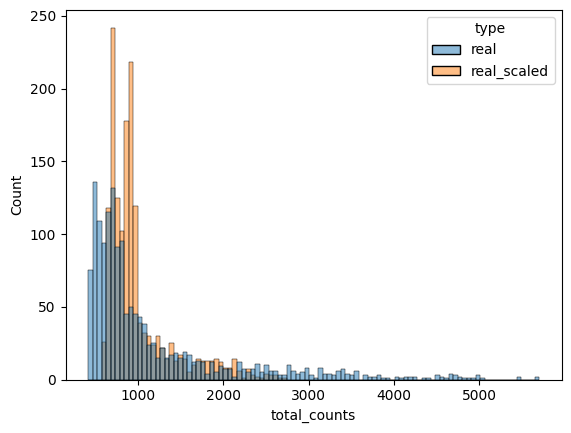

In [14]:
sns.histplot(cell_df[cell_df["type"].isin(["real", "real_scaled"])], x="total_counts", hue="type", bins=100)

<Axes: xlabel='total_counts', ylabel='Count'>

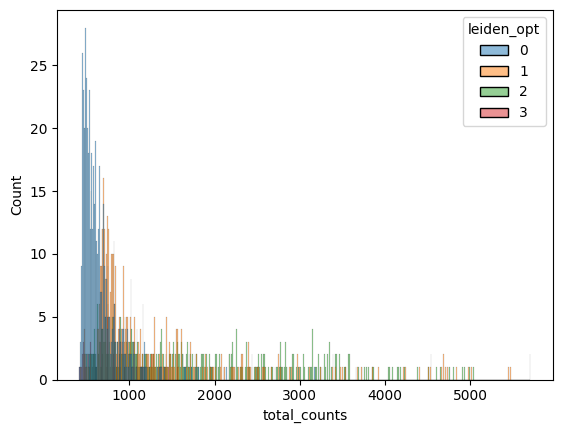

In [233]:
sns.histplot(cell_df[cell_df["type"].isin(["real"])], x="total_counts", hue="leiden_opt", binwidth=10)

<Axes: xlabel='total_counts', ylabel='Count'>

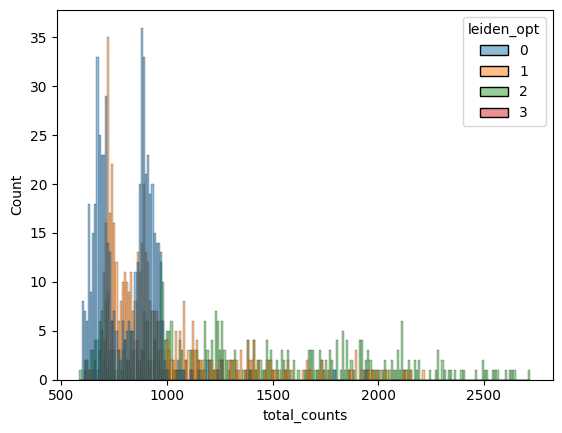

In [232]:
sns.histplot(cell_df[cell_df["type"].isin(["real_scaled"])], x="total_counts", hue="leiden_opt", binwidth=10)